****CON LOOP GIGANTE****

In [2]:
import os
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.datasets import load_wine
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cupy as cp
from statistics import mean
import json
import random


# For visual 
BOLD = "\033[1m"
END = "\033[0m"
GREEN = "\033[32m"
RED = "\033[31m"
ORANGE = "\033[38;5;208m" 
BLUE = "\033[34m"

def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

def load_xml_label(xml_path):
    tree = etree.parse(xml_path)
    root = tree.getroot()
    name = root.find('.//name').text
    return name

def load_data_from_directory(data_directory):
    X = []  # Features
    y = []  # Labels

    for filename in os.listdir(data_directory):
        if filename.endswith('.csv'):
            csv_path = data_directory + '/' + filename
            xml_path = csv_path.replace('csv', 'xml')
            if os.path.exists(xml_path):
                X.append(load_csv_data(csv_path))
                y.append(load_xml_label(xml_path))
            else:
                print("File not found!")
    print("\nLoading complete!")
    return X, y

# Carica i dati dal tuo percorso di directory contenente sia i file .csv che i file .xml
data_directory = "/Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi"
print("Loading datas from: " + data_directory)
X, y = load_data_from_directory(data_directory)
print("Datasets dimension:")
print(f"X shape: {len(X)}")
print(f"y shape: {len(y)}")


# I miei data al momento si trovano all'interno di una lista chiamata X contenente i dataFrame creati da ps
# per normalizzarli devo scorrere la lista e normalizzarne uno ad uno

flat_X = [df.values.flatten() for df in X]
X = np.vstack(flat_X)

n = 0
generations = 100
best_accuracy = 0
accuracy_test_best = 0
random_saver = 0

while n < generations:

    random_seed = random.randint(1, 10000)

    # Split dei dati in training set e test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)
    print("\nData splitted into training, validation and test sets")
    # Creazione del validation set
    X_train_2, X_val_temp, y_train_temp, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=random_seed)

    # Normalizzazione dei dati di training e validation
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.fit_transform(X_test)
    X_train_temp = scaler.fit_transform(X_train_2)
    X_val = scaler.fit_transform(X_val_temp)

    np.savetxt('X_train_norm.csv', X_train_norm, delimiter=',') # <---| Salvo i dati per effettuare un controllo su di essi e che non vi siano irregolarità |

    # Creiamo il classificatore SVM
    svm_classifier = SVC(random_state=random_seed) #Classifier

    # param_grid for bayesian optimization
    param_grid_bs = {

        'C': hp.loguniform('C', -3, 3),
        'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']), # Tipo di kernel utilizzato dalla SVM [linear, poly, rbf, sigmoid, precomputed]
        'gamma': hp.loguniform('gamma', -3, 3), # Aggiungi i valori per l'iperparametro "gamma"
        # 'C': hp.uniform('C', 1.5, 3), altri parametri
        # 'gamma': hp.uniform('gamma', 9, 11), altri parametri
    }

    scoring = ['accuracy']

    # Bayesian optimization for Hyper-parameters tuning

    # Funzione obiettivo
    def objective(param, X, y):

        svc = SVC(**param)
        scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise') # Cross-validation = 5, n_jobs = -1 means use all cores avaiables

        # best
        best_score = mean(scores)

        # min loss
        loss = -best_score

        return {'loss':loss, 'params':param, 'status':STATUS_OK}


    # Trials tracking process
    bayes_trials = Trials() 
    
    '''The model-based optimization algorithms used by hyperopt's fmin function work by analyzing samples of a response surface--a
      history of what points in the search space were tested, and what was discovered by those tests. 
      A Trials instance stores that history and makes it available to fmin and to the various optimization algorithms.'''

    print(f'\n\nIteration {n + 1}: - Random Seed: {random_seed}')

    # Optimization
    best = fmin(fn = lambda param: objective(param, X_train_temp, y_train_temp), #Pass X_train, y_train as parameters to objective
                    space = param_grid_bs, algo = tpe.suggest, max_evals = 220, trials = bayes_trials)

    # index best parameters
    print(best)

    # value best parameters
    print(space_eval(param_grid_bs, best))

    # Training using the best parameters found by the bayesian optimization
    svc_bs = SVC(C=space_eval(param_grid_bs, best)['C'], gamma=space_eval(param_grid_bs, best)['gamma'], kernel=space_eval(param_grid_bs, best)['kernel']).fit(X_train_temp, y_train_temp)

    # print best accuracy for testing
    accuracy_val = svc_bs.score(X_val, y_val)
    print(f'The accuracy score for the validation dataset is {accuracy_val:.4f}') 

    # All-time best validation set score
    if accuracy_val > best_accuracy:
        best_accuracy = accuracy_val
        best_hyperparameters = space_eval(param_grid_bs, best)
        accuracy_part = f'{BOLD}{GREEN}The best accuracy on the validation set is {END}'
        accuracy_value = f'{BOLD}{RED}{best_accuracy:.4f} {END}'
        hyperparameters_part = f'{BOLD}{GREEN}with hyperparameters: {END}'
        hyperparameters_value = f'{BOLD}{RED}{best_hyperparameters}{END}'
        random_seed_part = f'{BOLD}{GREEN}with random seed: {END}'
        random_seed_value = f'{BOLD}{GREEN}{random_seed}{END}'
        # Found a new best: best_accuracy = 0.9247, with hyperparameters: {'C': 1.661179450996574, 'gamma': 10.643118612567408, 'kernel': 'poly'}
        # just a comment with a good accuracy

        formatted_sentence = accuracy_part + accuracy_value + hyperparameters_part + hyperparameters_value + random_seed_part + random_seed_value

        print(formatted_sentence)

    svc_test = SVC(C = best_hyperparameters['C'], gamma = best_hyperparameters['gamma'], kernel = best_hyperparameters['kernel'])
    svc_test.fit(X_train_norm, y_train)
    y_pred = svc_test.predict(X_test_norm)
    accuracy_test = accuracy_score(y_test, y_pred)
    print(f'\nThe accuracy score on the test dataset, with this hyper-parameters is {BOLD}{BLUE}{accuracy_test:.4f}{END}')

    
    # All-time best test set score
    if accuracy_test > accuracy_test_best:
        accuracy_test_best = accuracy_test
        best_hyperparameters_test = best_hyperparameters
        print(f'\n{BOLD}{ORANGE}THAT\'S A NEW BEST!!{END}')
        random_saver = random_seed


    n = n + 1
    ###############################################################################################

    # 300:'C': 1.6530246210180544, 'gamma': 9.301052005520031, 'kernel': 'poly', accuracy 0.9022
    # Evaluate the best hyperparam on the test data set


#Salvataggio degli iperprametri con la maggior accuratezza trovata dal bayesian
param_grid_bs_str = json.dumps(best_hyperparameters_test)
file_name = "best_result.txt"
with open(file_name, 'a') as file:
    file.write("\n" + str(len(X)) + ": " + param_grid_bs_str + ", accuracy [" + str(accuracy_test_best) + "], random seed [" + str(random_saver) + ']')


Loading datas from: /Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi

Loading complete!
Datasets dimension:
X shape: 618
y shape: 618

Data splitted into training, validation and test sets


Iteration 1: - Random Seed: 2627
100%|██████████| 220/220 [05:59<00:00,  1.63s/trial, best loss: -0.7903225806451613]
{'C': 5.689703078164446, 'gamma': 0.37841046370029335, 'kernel': 1}
{'C': 5.689703078164446, 'gamma': 0.37841046370029335, 'kernel': 'poly'}
The accuracy score for the validation dataset is 0.7778
The best accuracy on the validation set is 0.7778 with hyperparameters: {'C': 5.689703078164446, 'gamma': 0.37841046370029335, 'kernel': 'poly'}with random seed: 2627

The accuracy score on the test dataset, with this hyper-parameters is 0.8710

THAT'S A NEW BEST!!

Data splitted into training, validation and test sets


Iteration 2: - Random Seed: 6273
100%|██████████| 220/220 [05:45<00:00,  1.57s/trial, best loss: -0.7903225806451613]
{'C': 2.7785511593726913, 'gamma': 0.05735971

KeyboardInterrupt: 

***SOLO FIT CON VISUALIZZAZIONE GRAFICA***

Loading datas from: /Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi

Loading complete!
Datasets dimension:
X shape: 618
y shape: 618

Data splitted into training, validation and test sets

The accuracy score on the test dataset is 0.9097


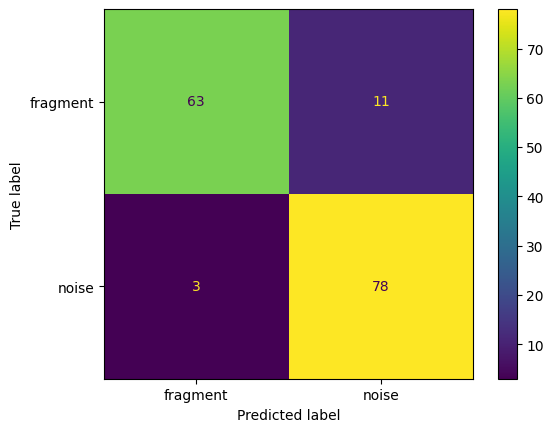

In [3]:
import os
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.datasets import load_wine
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cupy as cp
from statistics import mean
import json
import random


# For visual 
BOLD = "\033[1m"
END = "\033[0m"
GREEN = "\033[32m"
RED = "\033[31m"
ORANGE = "\033[38;5;208m" 
BLUE = "\033[34m"

def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

def load_xml_label(xml_path):
    tree = etree.parse(xml_path)
    root = tree.getroot()
    name = root.find('.//name').text
    return name

def load_data_from_directory(data_directory):
    X = []  # Features
    y = []  # Labels

    for filename in os.listdir(data_directory):
        if filename.endswith('.csv'):
            csv_path = data_directory + '/' + filename
            xml_path = csv_path.replace('csv', 'xml')
            if os.path.exists(xml_path):
                X.append(load_csv_data(csv_path))
                y.append(load_xml_label(xml_path))
            else:
                print("File not found!")
    print("\nLoading complete!")
    return X, y

# Carica i dati dal tuo percorso di directory contenente sia i file .csv che i file .xml
data_directory = "/Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi"
print("Loading datas from: " + data_directory)
X, y = load_data_from_directory(data_directory)
print("Datasets dimension:")
print(f"X shape: {len(X)}")
print(f"y shape: {len(y)}")


# I miei data al momento si trovano all'interno di una lista chiamata X contenente i dataFrame creati da ps
# per normalizzarli devo scorrere la lista e normalizzarne uno ad uno


flat_X = [df.values.flatten() for df in X]
X = np.vstack(flat_X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7930)
print("\nData splitted into training, validation and test sets")

# Normalizing
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

# Fitting with best hyperparameters found in previous code 
'''618:{'C': 3.764180544055172, 'gamma': 0.09993190961266894, 'kernel': 'poly'}, random_state = 7930''' 
# Creating classifier
svc_test = SVC(C = 3.764180544055172, gamma = 0.09993190961266894, kernel = "poly", random_state=7930)
svc_test.fit(X_train_norm, y_train)

# Predicition
y_pred = svc_test.predict(X_test_norm)

# Creating Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
accuracy_test = accuracy_score(y_test, y_pred)
print(f'\nThe accuracy score on the test dataset is {BOLD}{BLUE}{accuracy_test:.4f}{END}')
cm_display = ConfusionMatrixDisplay(cm, display_labels=svc_test.classes_).plot()

****SENZA LOOP****

In [12]:
import os
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cupy as cp
from statistics import mean
from sklearn.metrics import confusion_matrix
import json
import random
import re

# For visual 
BOLD = "\033[1m"
END = "\033[0m"
GREEN = "\033[32m"
RED = "\033[31m"
ORANGE = "\033[38;5;208m" 
BLUE = "\033[34m"

def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

def load_xml_label(xml_path):
    tree = etree.parse(xml_path)
    root = tree.getroot()
    name = root.find('.//name').text
    return name

def load_data_from_directory(data_directory):
    X = []  # Features
    y = []  # Labels

    for filename in os.listdir(data_directory):
        if filename.endswith('.csv'):
            csv_path = data_directory + '/' + filename
            xml_path = csv_path.replace('csv', 'xml')
            if os.path.exists(xml_path):
                X.append(load_csv_data(csv_path))
                y.append(load_xml_label(xml_path))
            else:
                print("File not found!")
    print("\nLoading complete!")
    return X, y

# Carica i dati dal tuo percorso di directory contenente sia i file .csv che i file .xml
data_directory = "/Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi"
print("Loading datas from: " + data_directory)
X, y = load_data_from_directory(data_directory)
print("Datasets dimension:")
print(f"X shape: {len(X)}")
print(f"y shape: {len(y)}")


# I miei data al momento si trovano all'interno di una lista chiamata X contenente i dataFrame creati da ps
# per normalizzarli devo scorrere la lista e normalizzarne uno ad uno

flat_X = [df.values.flatten() for df in X]
X = np.vstack(flat_X)

random_seed = random.randint(1, 10000)

# Split dei dati in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_seed)
X_train_2, X_val_temp, y_train_temp, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=random_seed)
print("\nData splitted into training, validation and test sets")

# Utilizziamo la TF-IDF per vettorizzare i dati CSV
# vectorizer = TfidfVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_val_vectorized = vectorizer.transform(X_val)
# X_test_vectorized = vectorizer.transform(X_test)

#Normalizzo i parametri con vettorizzazione
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_vectorized.toarray())  # Converto da matrice ad array
# X_val_scaled = scaler.transform(X_val_vectorized.toarray()) # Converto da matrice ad array
# X_test_scaled = scaler.transform(X_test_vectorized.toarray())


# Normalizzazione senza vettorizzazione
print("\nStarting normalization of each dataFrame (train, test)")
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)
X_train_temp = scaler.fit_transform(X_train_2)
X_val = scaler.fit_transform(X_val_temp)

print("\nNormalization completed!")

np.savetxt('X_train_norm.csv', X_train_norm, delimiter=',')

# print("Normalization completed successfully!")
# Creiamo il classificatore SVM

svm_classifier = SVC(random_state=random_seed) #Classifier

# Definisco gli iperparametri 
gamma_range = np.logspace(-10, 10, 21)
C_range = np.logspace(-10, 10, 21)

# param_grid for bayesian optimization
param_grid_bs = {

    'C': hp.loguniform('C', -3, 3),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']), # Tipo di kernel utilizzato dalla SVM
    # linear, poly, rbf, sigmoid, precomputed 
    'gamma': hp.loguniform('gamma', -3, 3), # Aggiungi i valori per l'iperparametro "gamma"

}

scoring = ['accuracy']

# Cross validation
################################################################################################
# Questo frammento di codice è utilizzato per una K-Fold cross-validation
# k_fold = sk.model_selection.KFold(n_splits=3, shuffle=True)
# grid_search = GridSearchCV(svm_classifier, param_grid, cv=k_fold)


# Questo frammento di codice è utilizzato per la cross-validation classica 
# Cerco di trovare i migliori iperparametri attraverso una cross-validation sul training set  
#   
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)  

# grid_search = GridSearchCV(svm_classifier, param_grid, cv=kfold, refit='accuracy', n_jobs=-1, scoring=scoring, verbose=3) # Verbose stampa il tempo di computazione per ogni fol


# grid_result = grid_search.fit(X_train_norm, y_train)

#################################################################################################

# Bayesian optimization for Hyper-parameters tuning

# Funzione obiettivo
def objective(param, X, y):

    svc = SVC(**param)
    scores = cross_val_score(svc, X, y, cv=5, scoring='accuracy', n_jobs=-1, error_score='raise')

    # best
    best_score = mean(scores)

    # min loss
    loss = -best_score

    return {'loss':loss, 'params':param, 'status':STATUS_OK}


# Trials tracking process
bayes_trials = Trials()


# Optimization
best = fmin(fn = lambda param: objective(param, X_train_temp, y_train_temp), #Pass X_train, y_train as parameters to objective
                 space = param_grid_bs, algo = tpe.suggest, max_evals = 500, trials = bayes_trials)

# index best parameters
print(best)

# value best parameters
print(space_eval(param_grid_bs, best))

# Training using the best parameters found by the bayesian optimization
svc_bs = SVC(C=space_eval(param_grid_bs, best)['C'], gamma=space_eval(param_grid_bs, best)['gamma'], kernel=space_eval(param_grid_bs, best)['kernel']).fit(X_train_temp, y_train_temp)

# print best accuracy for testing
accuracy_val = svc_bs.score(X_val, y_val)
print(f'The accuracy score for the validation dataset is {accuracy_val:.4f}') 


best_accuracy = accuracy_val
best_hyperparameters = space_eval(param_grid_bs, best)
accuracy_part = f'{BOLD}{GREEN}The best accuracy on the validation set is {END}'
accuracy_value = f'{BOLD}{RED}{best_accuracy:.4f} {END}'
hyperparameters_part = f'{BOLD}{GREEN}with hyperparameters: {END}'
hyperparameters_value = f'{BOLD}{RED}{best_hyperparameters}{END}'
# Found a new best: best_accuracy = 0.9247, with hyperparameters: {'C': 1.661179450996574, 'gamma': 10.643118612567408, 'kernel': 'poly'}
# just a comment with a good accuracy

formatted_sentence = accuracy_part + accuracy_value + hyperparameters_part + hyperparameters_value

print(formatted_sentence)

svc_test = SVC(C = best_hyperparameters['C'], gamma = best_hyperparameters['gamma'], kernel = best_hyperparameters['kernel'])
svc_test.fit(X_train_norm, y_train)
y_pred = svc_test.predict(X_test_norm)
accuracy_test = accuracy_score(y_test, y_pred)
print(f'\nThe accuracy score on the test dataset, with this hyper-parameters is {BOLD}{BLUE}{accuracy_test:.4f}{END}')

###############################################################################################

# 300:'C': 1.6530246210180544, 'gamma': 9.301052005520031, 'kernel': 'poly', accuracy 0.9022
# Evaluate the best hyperparam on the test data set

best_accuracy_test = 0
#Salvataggio degli iperprametri con la maggior accuratezza trovata dal bayesian
param_grid_bs_str = json.dumps(best_hyperparameters)
file_name = "best_result.txt"
with open(file_name, 'r') as file:
    for line in file:
        accuracy_match = re.search(r'accuracy ([\d.]+)', line)
        if accuracy_match:
            accuracy_in_file = float(accuracy_match.group(1))
            if accuracy_test > accuracy_in_file:
                best_accuracy_test = accuracy_test
                print(f'\n {BOLD}{ORANGE}THAT\'S A NEW BEST!!{END}')
                break

with open(file_name, 'a') as file:
    file.write("\n" + str(len(X)) + ": " + param_grid_bs_str + ", accuracy " + str(accuracy_test))



Loading datas from: /Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi

Loading complete!
Datasets dimension:
X shape: 618
y shape: 618

Data splitted into training, validation and test sets

Starting normalization of each dataFrame (train, test)

Normalization completed!
100%|██████████| 500/500 [20:48<00:00,  2.50s/trial, best loss: -0.8405063291139241]
{'C': 2.4877215934325068, 'gamma': 5.234752627077685, 'kernel': 1}
{'C': 2.4877215934325068, 'gamma': 5.234752627077685, 'kernel': 'poly'}
The accuracy score for the validation dataset is 0.7677
The best accuracy on the validation set is 0.7677 with hyperparameters: {'C': 2.4877215934325068, 'gamma': 5.234752627077685, 'kernel': 'poly'}

The accuracy score on the test dataset, with this hyper-parameters is 0.7984

 THAT'S A NEW BEST!!


In [4]:
import os
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, space_eval
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cupy as cp
from statistics import mean
from sklearn.metrics import confusion_matrix
import json

def load_csv_data(csv_path):
    return pd.read_csv(csv_path)

def load_xml_label(xml_path):
    tree = etree.parse(xml_path)
    root = tree.getroot()
    name = root.find('.//name').text
    return name

def load_data_from_directory(data_directory):
    X = []  # Features
    y = []  # Labels

    for filename in os.listdir(data_directory):
        if filename.endswith('.csv'):
            csv_path = data_directory + '/' + filename
            xml_path = csv_path.replace('csv', 'xml')
            if os.path.exists(xml_path):
                X.append(load_csv_data(csv_path))
                y.append(load_xml_label(xml_path))
            else:
                print("File not found!")
    print("\nLoading complete!")
    return X, y

# Carica i dati dal tuo percorso di directory contenente sia i file .csv che i file .xml
data_directory = "/Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi"
print("Loading datas from: " + data_directory)
X, y = load_data_from_directory(data_directory)
print("Datasets dimension:")
print(f"X shape: {len(X)}")
print(f"y shape: {len(y)}")


# I miei data al momento si trovano all'interno di una lista chiamata X contenente i dataFrame creati da ps
# per normalizzarli devo scorrere la lista e normalizzarne uno ad uno

flat_X = [df.values.flatten() for df in X]
X = np.vstack(flat_X)

# Split dei dati in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print("\nData splitted into training and test sets")

# Split del training set in training set e validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

# Utilizziamo la TF-IDF per vettorizzare i dati CSV
# vectorizer = TfidfVectorizer()
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_val_vectorized = vectorizer.transform(X_val)
# X_test_vectorized = vectorizer.transform(X_test)

#Normalizzo i parametri con vettorizzazione
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train_vectorized.toarray())  # Converto da matrice ad array
# X_val_scaled = scaler.transform(X_val_vectorized.toarray()) # Converto da matrice ad array
# X_test_scaled = scaler.transform(X_test_vectorized.toarray())


# Normalizzazione senza vettorizzazione
print("\nStarting normalization of each dataFrame (train, test)")
scaler = StandardScaler()
# X_val_scaled = scaler.transform(X_val) # Converto da matrice ad array
X_train_norm = scaler.fit_transform(X_train)
print("\n...")
X_test_norm = scaler.fit_transform(X_test)

print("\nNormalization completed!")

np.savetxt('X_train_norm.csv', X_train_norm, delimiter=',')

# print("Normalization completed successfully!")
# Creiamo il classificatore SVM

svm_classifier = SVC(random_state=1) #Classifier

# Definisco gli iperparametri 
gamma_range = np.logspace(-10, 10, 21)
C_range = np.logspace(-10, 10, 21)

'''
param_grid = {

    'C': np.logspace(-3, 2, 6),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Tipo di kernel utilizzato dalla SVM
    # linear, poly, rbf, sigmoid, precomputed 
    'gamma': gamma_range.tolist() +  ['auto', 'scale'] # Aggiungi i valori per l'iperparametro "gamma"
    
}'''

param_grid = {

    'C':np.logspace(-3, 2, 6),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Tipo di kernel utilizzato dalla SVM
    # linear, poly, rbf, sigmoid, precomputed 
    'gamma':  gamma_range.tolist() + ['scale', 'auto'] # Aggiungi i valori per l'iperparametro "gamma"

}



# param_grid for bayesian optimization
param_grid_bs = {

    # 'C': hp.loguniform('C', -3, 3),
    'C': hp.uniform('C', 1.5, 3),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']), # Tipo di kernel utilizzato dalla SVM
    'gamma': hp.uniform('gamma', 9, 11),
    # linear, poly, rbf, sigmoid, precomputed 
    # 'gamma': hp.loguniform('gamma', -3, 3), # Aggiungi i valori per l'iperparametro "gamma"

}

scoring = ['accuracy']

# Cross validation
################################################################################################
# Questo frammento di codice è utilizzato per una K-Fold cross-validation
# k_fold = sk.model_selection.KFold(n_splits=3, shuffle=True)
# grid_search = GridSearchCV(svm_classifier, param_grid, cv=k_fold)


# Questo frammento di codice è utilizzato per la cross-validation classica 
# Cerco di trovare i migliori iperparametri attraverso una cross-validation sul training set  
#   
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)  

# grid_search = GridSearchCV(svm_classifier, param_grid, cv=kfold, refit='accuracy', n_jobs=-1, scoring=scoring, verbose=3) # Verbose stampa il tempo di computazione per ogni fol


# grid_result = grid_search.fit(X_train_norm, y_train)

#################################################################################################

# Bayesian optimization for Hyper-parameters tuning

# Funzione obiettivo
def objective(param):

    svc = SVC(**param)
    scores = cross_val_score(svc, X_train_norm, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, error_score='raise')

    # best
    best_score = mean(scores)

    # min loss
    loss = -best_score

    return {'loss':loss, 'params':param, 'status':STATUS_OK}

# Trials tracking process
bayes_trials = Trials()

# Optimization
best = fmin(fn = objective, space = param_grid_bs, algo = tpe.suggest, max_evals = 600, trials = bayes_trials)

# index best parameters
print(best)

# value best parameters
print(space_eval(param_grid_bs, best))

# Training using the best parameters found by the bayesian optimization
svc_bs = SVC(C=space_eval(param_grid_bs, best)['C'], gamma=space_eval(param_grid_bs, best)['gamma'], kernel=space_eval(param_grid_bs, best)['kernel']).fit(X_train_norm, y_train)

# print best accuracy for testing
accuracy_test = svc_bs.score(X_test_norm, y_test)
print(f'The accuracy score for the testing dataset is {accuracy_test:.4f}') 
###############################################################################################

# 300:'C': 1.6530246210180544, 'gamma': 9.301052005520031, 'kernel': 'poly', accuracy 0.9022

#Salvataggio degli iperprametri con la maggior accuratezza trovata dal bayesian
param_grid_bs_str = json.dumps(space_eval(param_grid_bs, best))
file_name = "best_result.txt"
with open(file_name, 'a') as file:
    file.write("\n" + str(len(X)) + ": " + param_grid_bs_str + ", accuracy " + str(accuracy_test))

# Print the best accuracy score for the training dataset
## print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
## print(f'The best hyperparameters are {grid_result.best_params_}')
# Print the best accuracy score for the testing dataset
## print(f'The accuracy score for the testing dataset is {grid_search.score(X_test_norm, y_test):.4f}')


Loading datas from: /Users/Riccardo/Desktop/Progetto Scalogrammi/Scalogrammi

Loading complete!
Datasets dimension:
X shape: 618
y shape: 618

Data splitted into training and test sets

Starting normalization of each dataFrame (train, test)

...

Normalization completed!
100%|██████████| 600/600 [19:24<00:00,  1.94s/trial, best loss: -0.7991481636642928]
{'C': 1.9418042739186285, 'gamma': 10.407294205118141, 'kernel': 1}
{'C': 1.9418042739186285, 'gamma': 10.407294205118141, 'kernel': 'poly'}
The accuracy score for the testing dataset is 0.8968
